<h1><center>Neural Network Predictions of Sentiment in Customer Reviews</h1></center>
<center>
Kelseyann Wright <br>
Student ID: 00565814 <br>
College of Information Technology, Western Governors University <br>
Advanced Data Analytics - D213 Task 2 <br>
Instructor: Festus Elleh <br>
January 29, 2024 <br>
</center>

***

# <u>Part I: Research Question</u>

### A1: RESEARCH QUESTION
The question for this analysis is: "Can a natural language processing (NLP) with a neural network predict sentiment of customer reviews?"


### A2: OBJECTIVES OR GOALS

The goal of this analysis is to use customer reviews from IMDB, Amazon, and Yelp to develop a Neural Network for predicting customer sentiment (positive or negative). Being able to efficiently and accurately identify sentiment of customer reviews would allow the organization to identify products and/or services that should be of focus, either due to negative or positive sentiment. 


### A3: PRESCRIBED NETWORK

A recurrent neural network (RNN) will be used to analyze the customer review data and predict customer sentiment. In a recurrent neural network, there are "looping nodes", for which the output of the previous step serves as the input for the current step. This means that the outputs and inputs of each step are dependent on each other. In sentiment analysis, this is important because it allows the neural network to store past sequences in its memory enabling it to "remember" patterns and learn context from previous word sequences rather than just predicting based on individual words. The RNN for this analysis is a "many to one" network, meaning that the network will take a sequence of words as input and produce a single value, positive or negative sentiment, as an output.

# <u>Part II: Data Preparation</u>

In [1]:
#SET UP ENVIRONMENT
#import packages
import warnings
warnings.filterwarnings("ignore") #filter warnings out

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


import pandas as pd

import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from wordcloud import WordCloud

import keras
from keras.preprocessing.text import Tokenizer as Tokenizer
from keras import layers
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')    
nltk.download('stopwords')


2024-02-04 14:30:59.440289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True


### B1: DATA EXPLORATION

<b><i>CLEANING</b></i><br><br>
Prior to data exploration, preliminary cleaning of the data was performed. All three datasets (IMDB, Yelp, and Amazon) were loaded and concatenated, resulting in a dataframe with 3000 entries. No nulls were identified. After loading the data, all letters were converted to lowercase and punctuation was removed. Stopwords, which are commonly used words such as 'and', were removed.

In [2]:
#LOAD AND PREVIEW DATA
df_imdb = pd.read_csv("~/Desktop/WGU/D213/imdb_labelled.txt", sep='\t', header = None, names = ['Review', 'Sentiment'], index_col=False, quoting=csv.QUOTE_NONE)
df_amazon = pd.read_csv("~/Desktop/WGU/D213/amazon_cells_labelled.txt", sep='\t', header = None, names = ['Review', 'Sentiment'], index_col=False, quoting=csv.QUOTE_NONE)
df_yelp = pd.read_csv("~/Desktop/WGU/D213/yelp_labelled.txt", sep='\t', header = None, names = ['Review', 'Sentiment'], index_col=False, quoting=csv.QUOTE_NONE)
df = pd.concat((df_imdb, df_amazon, df_yelp), ignore_index = True)

print('Data Preview:')
print(df.head())
print('\n Shape of Dataframe:', df.shape, '\n')
print(df.info())

Data Preview:
                                              Review  Sentiment
0  A very, very, very slow-moving, aimless movie ...          0
1  Not sure who was more lost - the flat characte...          0
2  Attempting artiness with black & white and cle...          0
3       Very little music or anything to speak of.            0
4  The best scene in the movie was when Gerardo i...          1

 Shape of Dataframe: (3000, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     3000 non-null   object
 1   Sentiment  3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB
None


In [3]:
#CLEANING - lowercase and remove punctuation
df['Review'] = df['Review'].str.lower() #make all text lowercase
df['Review'] = df['Review'].str.replace('[^\w\s]','') #remove punctuation

In [4]:
#REMOVE STOP WORDS AND TOKENIZE
stop_words = nltk.corpus.stopwords.words('english') #create list of stop_words
tok_dat = []
for s in df.Review:
    tok_dat.append([w for w in word_tokenize(s) if w not in stop_words])

<b><i>UNUSUAL CHARACTERS</b></i><br><br>
No emojis or unusual characters were identified in the dataset. The most 'unusual' words were ones that included both numbers and letters, likely resulting from typos. There were 125 words that were composed of letters and numbers together or only numbers (see below). These were removed from the dataset in order to ensure that the only characters remaining in the dataset were alphabetic. 

In [6]:
#find unusual characters (not letters)
notalpha = list(filter(None, [[w for w in r if not w.isalpha()] for r in tok_dat]))
notalnum = list(filter(None, [[w for w in r if not w.isalnum()] for r in tok_dat]))

print('Number of NOT alpha words:', len(pd.unique(pd.Series([w for r in notalpha for w in r]))))
if len(notalpha) != 0:
    print(pd.unique(pd.Series([w for r in notalpha for w in r])))

print()
print('Number of NOT alphanumeric words:', len(pd.unique(pd.Series([w for r in notalnum for w in r]))))
if len(notalnum) != 0:
    print(pd.unique(pd.Series([w for r in notalnum for w in r])))
    
tok_dat = [[w for w in s if w.isalpha()] for s in tok_dat] #remove notalpha words from data

Number of NOT alpha words: 125
['pg13' '2' '9' '10' '1010' '1' 'mst3k' '750' '80s' '25' '5year' '5' '8'
 '90' '70000' '95' '1980s' '3' '4' '20the' '110' '010' '15' '810' '30'
 '12' '2006' 'nc17' '20th' '1948' '1928' '80' '1947' '1986' '1995' '90s'
 '1971' '70s' '1973' '18th' '20' '40' '1949' '50' '54' '8pm' '815pm' '910'
 '1998' '2005' '45' '7' '680' '2mp' '510' 'mp3' 'situations1'
 'd807wrongly' 'd807' '6' '375' '350' 'jabra350' '13' '8530' 'w810i' 'l7c'
 'hs850' 'v115g' 'h500' 'good7' 'frequently4' 'v3i' '2160' '23' 'phones2'
 's11' '2000' 'jx10' 'gx2' 'bt50' 'vx9900' 'bt250v' '11' '5of' '5020' '24'
 'e715' '700w' 'phonesmp3' 'e2' '325' 'ca42' 'mp3s' 'v325i' '3o' '18' '4s'
 '100' 'good4' '5320' 'schr450' '42' 'ps3' '744' 'v3c' 'v265' 'be3' '8125'
 '8525' 's710a' 'z500a' '40min' '1979' '400' '17' '15lb' '34ths' '35' '70'
 'atmosphere1' '2007' '30s' '785' '1199']

Number of NOT alphanumeric words: 0


<b><i>VOCABULARY SIZE</b></i><br><br>
After removing all words containing non-alphabetic characters, the 'WordNetLemmatizer' function from the NLTK package was used to lemmatize words. Lemmatization reduces words to their base words while retaining their meaning. For example, it would reduce "running" to "run". An example comparing an original review to the prepared review is provided below. Lemmatization is important because it reduces the vocabulary size and correlation between like words, making the RNN more efficient. This preprocessing resulted in a vocabulary size of 4424. A wordcloud was generated to preview the vocabulary set, and is shown below. 

In [8]:
#LEMMATIZATION
tok_dat = [[WordNetLemmatizer().lemmatize(w, "v") for w in r] for r in tok_dat] #lemmatize
print('Original Review:  ', df.iloc[0,0])
print('Prepared Review:  ', tok_dat[0])

Original Review:   a very very very slowmoving aimless movie about a distressed drifting young man  
Prepared Review:   ['slowmoving', 'aimless', 'movie', 'distress', 'drift', 'young', 'man']


In [58]:
#VECTORIZE AND DETERMINE FINAL VOCAB SIZE
tok = Tokenizer(num_words=None)
tok.fit_on_texts(tok_dat)
tokvals = tok.texts_to_sequences(tok_dat)
vocsize = len(tok.word_index) + 1 

print('REDUCED VOCABULARY SIZE AFTER PRE-PROCESSING: ', vocsize)
print('NUMBER OF REVIEWS AFTER PREPROCESSING:', len(tok_dat))

REDUCED VOCABULARY SIZE AFTER PRE-PROCESSING:  4424
NUMBER OF REVIEWS AFTER PREPROCESSING: 3000


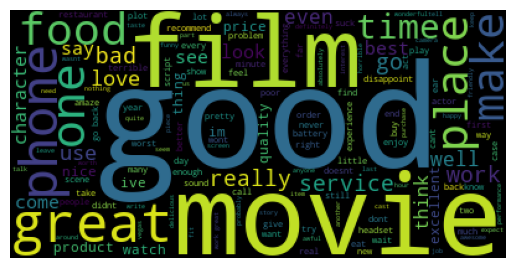

In [11]:
#MAKE WORDCLOUD
flat_list = str()
for r in tok_dat:
    for w in r:
        flat_list = flat_list + ' ' + w
wordcloud_fig = WordCloud().generate(flat_list)
plt.axis('off')
plt.imshow(wordcloud_fig)

<b><i>PROPOSED WORD EMBEDDING LENGTH</b></i><br><br>
Word embedding length is often calculated as the fourth root of the vocab size. Using this calculating the estimated word embedding length for a vocabulary size of 4423 words is 9. The code for the calculation is provided below. 

In [59]:
calc_embed_len = round(np.ceil(vocsize**(1/4)))
print('Estimated Word Embedding Length: ', calc_embed_len)

Estimated Word Embedding Length:  9


<b><i>JUSTIFICATION OF THE MAXIMUM SEQUENCE LENGTH</b></i><br><br>
The longest review in the cleaned dataset is 41 words. In order to compare this to the length of other reviews in the dataset, a density plot and historgram of review lengths was generated (see below). According to these figures, reviews of this length (41 words) are rare. In fact, the 99th percentile of review length is only 20 words. For this reason, the 99th percentile value of 20 will be used as the maximum sequence length. Reviews will be padded or truncated to this length for the RNN.

In [60]:
#longest review
wordcounts = [len(r) for r in tok_dat]
maxwords = max(wordcounts)
print('Length of Longest Review: ', maxwords, ' words')
print(tok_dat[wordcounts.index(maxwords)])

Length of Longest Review:  41  words
['masterful', 'piece', 'filmmaking', 'many', 'theme', 'simmer', 'occasionally', 'boil', 'warts', 'study', 'poets', 'bohemian', 'selfindulgent', 'wartime', 'years', 'span', 'aerial', 'bombardments', 'london', 'outward', 'tranquillity', 'welsh', 'coastal', 'retreat', 'borderlines', 'friendship', 'lust', 'love', 'dedication', 'art', 'experience', 'versus', 'practical', 'concern', 'jealousy', 'rivalry', 'cowardice', 'egotism', 'versus', 'heroism', 'selfsacrifice']


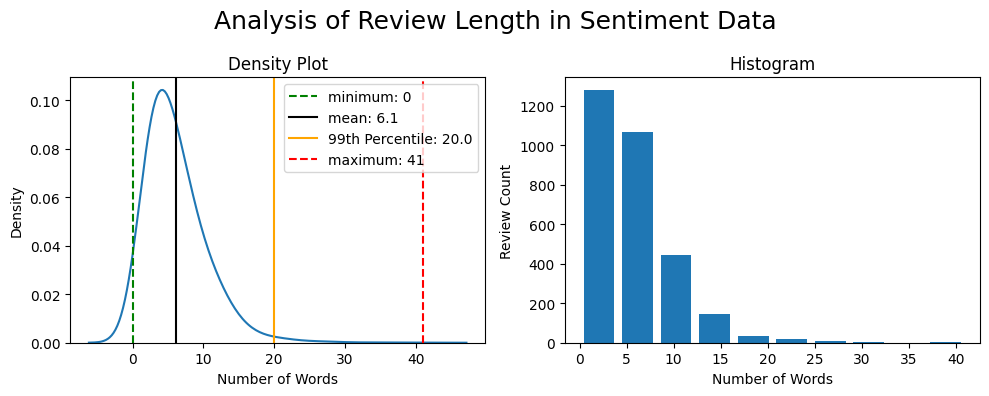

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1,2,1)
axs[0] = sns.kdeplot(wordcounts, bw_method=0.5)
axs[0].axvline(x=min(wordcounts), color = 'green', label='minimum: ' + str(min(wordcounts)), linestyle='dashed')
axs[0].axvline(x=np.mean(wordcounts), color = 'black', label='mean: ' + str(round(np.mean(wordcounts), 2)))
axs[0].axvline(x=np.quantile(wordcounts, 0.99), color = 'orange', label='99th Percentile: ' + str(round(np.quantile(wordcounts, 0.99), 2)))
axs[0].axvline(x=max(wordcounts), color = 'red', label='maximum: ' + str(max(wordcounts)), linestyle='dashed')
axs[0].legend()
axs[0].set_xlabel('Number of Words')
axs[0].set_title('Density Plot')

plt.subplot(1,2,2)
plt.hist(wordcounts, rwidth=0.8)
axs[1].set_xlabel('Number of Words')
axs[1].set_ylabel('Review Count')
axs[1].set_title('Histogram')

plt.suptitle('Analysis of Review Length in Sentiment Data', fontsize=18)
plt.tight_layout()
plt.show()

In [61]:
maxseqlen = round(np.quantile(wordcounts, 0.99))
print('Maximum Sequence Length for Model (99th Percentile):', maxseqlen)

Maximum Sequence Length for Model (99th Percentile): 20


### B2: TOKENIZATION

Tokenization was performed during data exploration when stop words were removed (code section 4). The tokenization process splits the each review into a list of words. This way, each word can be isolated for analysis. Because mathematic models require numeric inputs, each unique word in the dataset is assigned a numeric value. Then, each review is converted to a list of numbers to be fed into the model. The word index (shown below) can be used to match word tokens to their numeric index. 


In [62]:
print('Tokenized Word Index PREVIEW (first 25): ')
print({k:val for k, val in tok.word_index.items() if val<=25}, '\n\n')

print('Token Example: ', tok_dat[0])
print('Corresponding Numeric Values: ', tokvals[0])

Tokenized Word Index PREVIEW (first 25): 
{'good': 1, 'great': 2, 'film': 3, 'movie': 4, 'phone': 5, 'one': 6, 'like': 7, 'work': 8, 'time': 9, 'place': 10, 'make': 11, 'go': 12, 'get': 13, 'food': 14, 'service': 15, 'really': 16, 'bad': 17, 'use': 18, 'love': 19, 'well': 20, 'dont': 21, 'would': 22, 'even': 23, 'best': 24, 'see': 25} 


Token Example:  ['slowmoving', 'aimless', 'movie', 'distress', 'drift', 'young', 'man']
Corresponding Numeric Values:  [1820, 1821, 4, 1822, 1218, 720, 236]


### B3: PADDING PROCESS

Padding was used to standardize the length of sequences. As stated in section B1, the maximum sequence length chosen for this analysis was 20 words. There are some reviews in the dataset that have fewer than twenty words, and some with more than twenty words. Reviews that contain less than twenty words were padded by adding zeros after the text sequence until the sequence contained 20 values. Reviews longer than 20 words were truncated to the first 20 words in the sequence. This is a required step for RNN as it is necessary for all input sequences to be the same length. The code and a preview of a single padded sequence is provided below. 

In [63]:
x_pad = pad_sequences(tokvals, padding='post', maxlen = maxseqlen)
print('Padded Array Dimensions: ', x_pad.shape, '\n')
print('Preview Sequence: \n', x_pad[0,:])

Padded Array Dimensions:  (3000, 20) 

Preview Sequence: 
 [1820 1821    4 1822 1218  720  236    0    0    0    0    0    0    0
    0    0    0    0    0    0]


### B4: CATEGORIES OF SENTIMENT

There are two sentiment categories in the data - positive (1) and negative (0). There are 1500 reviews for each category of sentiment present int he dataset (see below). For outputs with values of 0 or 1, a sigmoid activation function is appropriate and will be used for this analysis (Brownlee, 2021).


In [65]:
print(df['Sentiment'].value_counts()) #print number of positive and negitive sentiments

0    1500
1    1500
Name: Sentiment, dtype: int64


### B5: STEPS TO PREPARE THE DATA
The primary steps used to prepare the data are discussed in detail in sections B1-B3. In summary, the data preparation process was:
1) Load and combine the three provided datasets and 
2) Check for nulls and remove if present (there were none)
3) Clean data by removing punctuation and transforming to lowercase
4) Remove stop words and non-alphabetic words
5) Tokenize
6) Pad to maximum sequence length

After completion of the preprocessing steps above, the data was split into training, test, and validation data. The training set includes 60% of the dataset, and the test and validation datasets were each comprised of 20% of the dataset. The validation set will be used for validation during model training. The test set will be used for analysis of model performance after training is complete.

In [66]:
y = np.array(df['Sentiment']) #create array of sentiment scores

#split the data (y and x_pad) into train, test, and validation sets
x_train, x_check, y_train, y_check = train_test_split(x_pad, y, test_size = 0.40, random_state=55)
x_test, x_val, y_test, y_val = train_test_split(x_check, y_check, test_size = 0.50, random_state=55)

print('TRAIN - 60%:  x_train shape: ', x_train.shape, '  y_train length: ', y_train.shape)
print('VALIDATE - 20%:  x_val shape: ', x_val.shape, '  y_val length: ', y_val.shape)
print('TEST DATA - 20%:  x_test shape: ', x_test.shape, '  y_test length: ', y_test.shape)


TRAIN - 60%:  x_train shape:  (1800, 20)   y_train length:  (1800,)
VALIDATE - 20%:  x_val shape:  (600, 20)   y_val length:  (600,)
TEST DATA - 20%:  x_test shape:  (600, 20)   y_test length:  (600,)



### B6: PREPARED DATA SET

The datasets were exported to CSV files and attached to this assessment as Xtrain_T2.csv, Ytrain_T2.csv, Xtest_T2.csv, ytest_T2.csv, Xval_T2.csv, and Yval_T2.csv.


In [67]:
pd.DataFrame(x_train).to_csv("~/Desktop/WGU/D213/Xtrain_T2.csv")
pd.DataFrame(y_train).to_csv("~/Desktop/WGU/D213/Ytrain_T2.csv")
pd.DataFrame(x_test).to_csv("~/Desktop/WGU/D213/Xtest_T2.csv")
pd.DataFrame(y_test).to_csv("~/Desktop/WGU/D213/Ytest_T2.csv")
pd.DataFrame(x_val).to_csv("~/Desktop/WGU/D213/Xval_T2.csv")
pd.DataFrame(y_val).to_csv("~/Desktop/WGU/D213/Yval_T2.csv")


# <u> Part III: Network Architecture</u>


In [154]:
#calculate hyperparameter for LSTM
alpha = 1 #scalar for LSTM number of layers
Nh = int((len(y_train)/(alpha*(maxseqlen * 26))))

In [167]:
#Setup model
NNmodel = keras.Sequential()
NNmodel.add(layers.Embedding(input_dim = vocsize, #size of vocabulary
                             output_dim = calc_embed_len, #size of embedding space
                             input_length=maxseqlen, #sequence size
                             mask_zero = True #padded with zeros - ignore them in model
                             ) 
            ) 
NNmodel.add((layers.LSTM(Nh))) #Long short term memory layer
NNmodel.add(layers.Dropout(0.4)) #avoid overfitting
NNmodel.add(layers.Dense(1, activation='sigmoid')) #output layer
NNmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


### C1: MODEL SUMMARY


The model summary using the TensorFlow summary function is provided below. This summary shows the layers in the RNN aas well as the total number of trainable and non-trainable parameters. 

In [161]:
NNmodel.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 20, 9)             39816     
                                                                 
 lstm_25 (LSTM)              (None, 3)                 156       
                                                                 
 dropout_25 (Dropout)        (None, 3)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)                 4         
                                                                 
Total params: 39976 (156.16 KB)
Trainable params: 39976 (156.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### C2: NETWORK ARCHITECTURE

The RNN consists of four total layers: embedding, long short term memory (LSTM), dropout, and a dense layer. The total number of parameters, based on the model summary above, is 39976. All of these parameters are trainable. There are no non-trainable parameters in the model.


### C3: HYPERPARAMETERS

<b><i>Activation Function</b></i><br>
A sigmoid activation function was used. Sigmoid activation functions are appropriate for binary output values of 0 and 1 (Brownlee, 2021). The predicted sentiment values are either 0 (negative) or 1 (positive), which is consistent with a sigmoid activation function. 

<br><b><i>Number of Nodes per Layer</b></i><br>
The embedding layer consists of one node for each input. The length of the input sequence is 20, indicating that there are 20 nodes for the embedding layer. The LSTM layer contains three nodes, calculated as: <br><center>N<sub>h</sub> =  N<sub>s</sub>/(alpha*(N<sub>i</sub> * N<sub>o</sub>)) </center></br> where N<sub>h</sub> is the number of nodes, N<sub>s</sub> is the number of samples in the training set, alpha is a scalar value (set to one for this analysis based on trial and error), N<sub>i</sub> is the length of the input sequence, and N<sub>o</sub> is the number of characters (Ekhardt, 2018). The dropout layer also includes 3 nodes to correspond with the LSTM layer, although individual nodes are excluded from some training runs as part of the dropout function to prevent overfitting. The hyperparameter for the dropout layer is 0.4, or 40% of neurons. This value was determined by testing dropout values between 20% and 50% and choosing the value that reduced overfitting without inducing underfitting (Brownlee, 2022). Finally, the dense layer includes one node to correspond with the length of the output seqence, which in this case is a single value, 0 or 1, representing negative or positive sentiment, respectively. 

<br><b><i>Loss Function</b></i><br>
The binary cross entropy loss function was used. Binary cross entropy loss functions are appropriate for binary outcomes (Saxena, 2023), which is consistent with our output values of 0 or 1. The loss function measures the dissimilarity between predicted and actual values, pennalizing predictions based on their distance from the expected outcome (Saxena, 2023).

<br><b><i>Optimizer</b></i><br>
The adaptive moment estimation optimizer (ADAM) was used. The ADAM optimizer adjusts learning rates throughout the training process (Gupta, 2024). The adaptive behavior of the ADAM optimizer tends to result in faster convergence and improved neural network performance (Gupta, 2024).

<br><b><i>Stopping Criteria</b></i><br>
The number of epochs was set to 30, but with an early stopping function that monitors the validation loss and will stop fitting when the minimum validation loss is achieved (with a patience value of two epochs in order to avoid stopping due to noise). The patience value was determined using trial and error, iteratively running the model with different patience values and monitoring for overfitting (Brownlee, 2020). The validation loss was used as the stopping criteria as an increase in validation loss tended to be the first sign of overfitting during the various training runs. 

<br><b><i>Evaluation Metric</b></i><br>
Accuracy will be used as the evaluation metric for the neural network. Accuracy is the proportion of predictions that match the expected values. Accuracy will be calculated for the training, validation, and test data. See section D4 for a description of predictive accuracy.


# <u>Part IV: Model Evaluation</u>



### D1: STOPPING CRITERIA

The keras "Early Stopping" callback was used to implement stopping criteria for the RNN. In the fitting of the model, the number of epochs was set to 30. However, the early stopping call back was used to monitor the validation loss metric thorughout the training process, and stop training once the minimum validation loss was reached. The 'patience' argument was set to 2 in order to ensure 2 consecutive runs without decreasing loss prior to stopping the model fitting process. This ensures that the stopping was due to reaching the true minimum (Brownlee, 2020). The patience value was selected based on trial and error and monitoring for overfitting. Even though the number of epochs was set to 30, the neural network was able to converge in less than 10 epochs. The output of the model fit with evaluation metrics for each epoch is shown below. 

In [168]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 2) #stopping function
modfit = NNmodel.fit(x_train, y_train, 
                     epochs=30, 
                     validation_data=(x_val, y_val), 
                     callbacks = [es])

Epoch 1/30
57/57 [==============================] - 11s 65ms/step - loss: 0.6917 - accuracy: 0.5428 - val_loss: 0.6902 - val_accuracy: 0.6550
Epoch 2/30
57/57 [==============================] - 2s 36ms/step - loss: 0.6857 - accuracy: 0.6694 - val_loss: 0.6840 - val_accuracy: 0.6717
Epoch 3/30
57/57 [==============================] - 2s 40ms/step - loss: 0.6654 - accuracy: 0.7772 - val_loss: 0.6634 - val_accuracy: 0.7083
Epoch 4/30
57/57 [==============================] - 2s 32ms/step - loss: 0.6050 - accuracy: 0.8444 - val_loss: 0.6088 - val_accuracy: 0.7467
Epoch 5/30
57/57 [==============================] - 2s 39ms/step - loss: 0.4851 - accuracy: 0.8756 - val_loss: 0.5409 - val_accuracy: 0.7500
Epoch 6/30
57/57 [==============================] - 2s 33ms/step - loss: 0.3828 - accuracy: 0.8933 - val_loss: 0.5169 - val_accuracy: 0.7633
Epoch 7/30
57/57 [==============================] - 2s 43ms/step - loss: 0.3186 - accuracy: 0.9044 - val_loss: 0.5207 - val_accuracy: 0.7617
Epoch 8/30
5

### D2: FITNESS
During the fitting process, accuracy increaes rapidly initially and then the rate of improvement slows. This pattern is representative of a good model fitting process. Loss decreases quickly initially and then the rate of decrease slows. For validation loss, we can see a slight increase for the last two epochs, indicating the beginning of overfitting. However, the increase is minimal (less than 2%). The stopping criteria included a patience value of two, which is why the increase is visible over the last two epochs. This patience value was inititally tested at larger values, however overfitting was greatly apparent at patience values of 3 or higher. However, lowering the patience value to 1 could result in convergence at local minima and early stopping rather than reaching the absolute minimum (Brownlee, 2020). In addition to adjusting the patience argument in the early stopping callback, the percent provided as the hyperparameter for the dropout layer was increased from 20% to 40% to reduce overfitting. This parameter was tested at 20%, 30%, 40%, and 50%. The dropoout value of 40% resulted in the least amount of overfitting, while 50% began to show evidence of underfitting. Overall, the training process appears to have converged at an appropriate minimum for validation loss while maximizing accuracy with minimal overfitting. 


### D3: TRAINING PROCESS
Line graphs of accuracy and loss for training and validation data during the training process are provided below. 

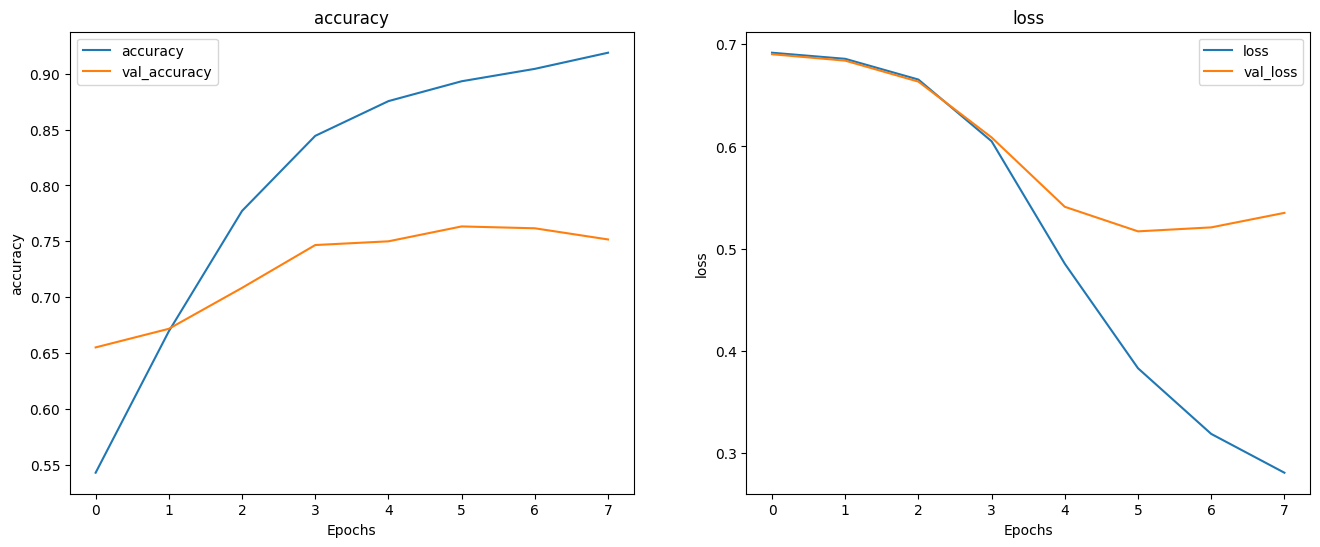

In [170]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.title(metric)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(modfit, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(modfit, 'loss')


### D4: PREDICTIVE ACCURACY
Accuracy was calculated for the training, validation, and test data using the evaluate function in keras (see below). The training accuracy was 96%, The validation accuracy was 75%, and the testing accuracy was 80%. The training accuracy being higher than the validation and test accuracy is expected. According to the testing accuracy, 80% of model predictions accurately matched epected outcomes. This means that the model is able to predict customer sentiment in reviews with 80% accuracy.

In [180]:
train_loss, train_acc = NNmodel.evaluate(x_train, y_train, verbose=False)
valid_loss, valid_acc = NNmodel.evaluate(x_val, y_val, verbose=False)
test_loss, test_acc = NNmodel.evaluate(x_test, y_test, verbose=False)

print('Training Accuracy:', round(train_acc*100), '%)
print('Validation Accuracy:', round(valid_acc*100), '%')
print('Test Accuracy:', round(test_acc*100), '%') 

Training Accuracy: 96 %
Validation Accuracy: 75 %
Test Accuracy: 80 %



# <u>Part V: Summary and Recommendations</u>


### E: CODE
All code is included in this jupyter notebook, attached as an .html file for easy viewing and an .ipynb file for execution testing.


### F: FUNCTIONALITY
Overall, the neural network functions well. 96% training accuracy and 80% testing accuracy are indicitive of strong predictive capabilities. The model structure is fairly simple with only four layers and relatively few nodes at each layer. The ADAM optimizer and addition of the early stopping callback allowed the neural network to achieve minimum validation loss and converge quickly, in less than 10 epochs in around 30 seconds. The neural network can be used with moderate confidence to make predictions about customer sentiment in reviews, but it should be noted that it can only do so with 80% accuracy. 

### G: RECOMMENDATIONS
Based on these results, the neural network can be deployed and used to make predictions of customer sentiment from reviews with 80% accuracy. Accuracy improvement may be possible by adding complexity to the neural network, such as additional layers or nodes in layers. Using machine learning to tune hyperparameters is also an option, as it may result in better parameters that were not tested during the manual trial and error process. I recommend using the model in its current state, with awareness of the 20% chance of inaccurate predictions, while continuing to test different variations of the model and updating the dataset as more reviews become available.  


# <u>Part VI: Reporting</u>


### H: REPORTING
An HTML of the jupyter notebook was attached to the assessment. 



### I: SOURCES OF THIRD PARTY CODE
Brownlee, J. (2020). Use Early Training to Halt the Training of Neural Networks At the Right Time. Machine Learning Mastery. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/. [Used for accuracy and loss graphing, section D3]


### J: SOURCES
Brownlee, J. (2020). Use Early Training to Halt the Training of Neural Networks At the Right Time. Machine Learning Mastery. https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/.

Brownlee, J. (2021). How to choose an activation function for deep learning. Machine Learning Mastery. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

Brownlee, J. (2022). Dropout Regularization in Deep Learning Models with Keras. Machine Learning Mastery. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

Eckhardt, K. (2018). Choosing the right hyperparameters for a simple LSTM using Keras. Towards Data Science. https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

Gupta, A. (2024). A comprehensive guide on optimizers in deep learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

Sexena, S. (2023). Binary cross entropy/log loss for binary classification. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/#:~:text=Binary%20Cross%20Entropy%20is%20a,outcomes%20and%20actual%20binary%20labels.
